In [6]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [8]:
from sam2.build_sam import build_sam2_video_predictor
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [9]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

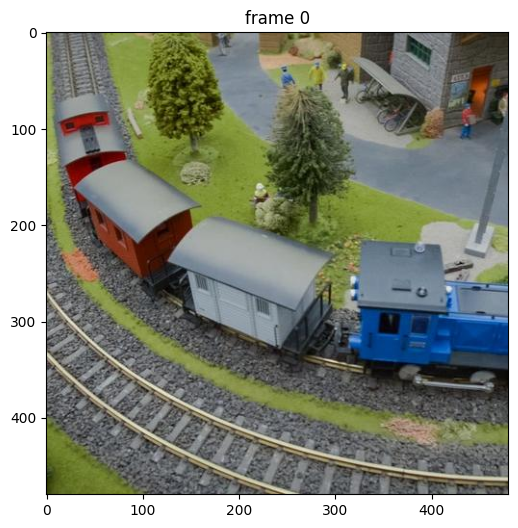

In [11]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
#video_dir = "./videos/bedroom"
video_dir = "/home/shijie/Desktop/work/feature-4dgs/data/davis_dev/train/code_output/images"
#video_dir = "/home/shijie/Desktop/work/feature-4dgs/data/davis_dev/train/code_output/log/native_feat_davis.yaml_compactgs_dep=uni_gt_cam=False_lrfeat=0.0005_20241029_225057/final_viz/training_moving_rgb"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
image = Image.open(os.path.join(video_dir, frame_names[frame_idx]))
image = np.array(image.convert("RGB"))

plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(image)

In [13]:
import os.path as osp

data_dir = "/home/shijie/Desktop/work/feature-4dgs/data/davis_dev/train/code_output/semantic_features"

sam2_path = osp.join(data_dir, "sam2_feats.pth")
sam2_feats = torch.load(sam2_path)

# mosca_path = osp.join(data_dir, "/home/shijie/Desktop/work/feature-4dgs/data/davis_dev/train/code_output/log/native_feat_davis.yaml_compactgs_dep=uni_gt_cam=False_lrfeat=0.0005_20241029_225057/final_viz/training_moving/rendered_results.pth")
# render_dicts = torch.load(mosca_path)

# for frame_idx in range(len(render_dicts)):
#     rendered_feat = render_dicts[frame_idx]["feature_map"].unsqueeze(0) # [1, 256, 64, 64]

#     sam2_feats[frame_idx]['backbone_fpn'][0] = rendered_feat
#     sam2_feats[frame_idx]['vision_pos_enc'][0] = torch.zeros(1, 256, 64, 64) #rendered_feat

#rgb_feats = torch.zeros(len(render_dicts), 3, 480, 480)
rgb_feats = torch.zeros(80, 3, 480, 480)

inference_state = predictor.novel_view_inference_init( sam2_feats=sam2_feats, rgb_feats=rgb_feats) 

In [ ]:
# masks = mask_generator.generate(image)
# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# show_anns(masks)
# plt.axis('off')
# plt.show() 
# print(len(masks))

In [ ]:
# # add each mask from automatic mask generator to predictor

# ann_frame_idx = 0  # the frame index we interact with
# for i in range(len(masks)):
#     _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
#         inference_state=inference_state,
#         frame_idx=ann_frame_idx,
#         obj_id= i,
#         mask=masks[i]["segmentation"]
#     )

# # show the results on the current (interacted) frame
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

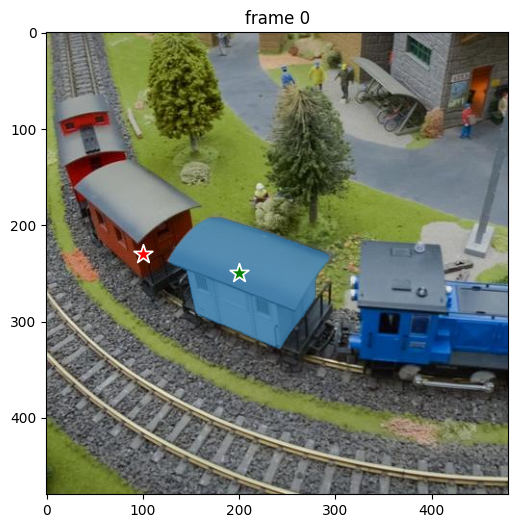

In [14]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)

# # add a box 
# H = image.shape[0]
# W = image.shape[1]
# #box = [0, 0, W, H]
# box = [130, 220, 300, 350]
# _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     box=box
# )
# # show the results on the current (interacted) frame
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_box(box, plt.gca())
# show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])


# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[200, 250],[100,230]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [15]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

points = np.array([[400, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=1,
    points=points,
    labels=labels,
)

points = np.array([[100, 200], [100, 230]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=2,
    points=points,
    labels=labels,
)


propagate in video: 100%|██████████| 80/80 [00:03<00:00, 20.58it/s]


torch.Size([240, 256, 64, 64])


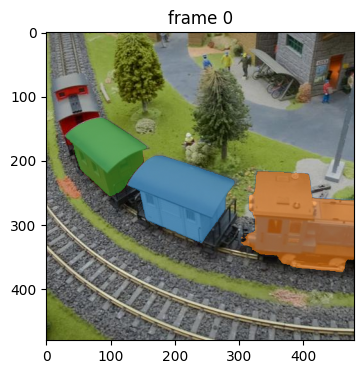

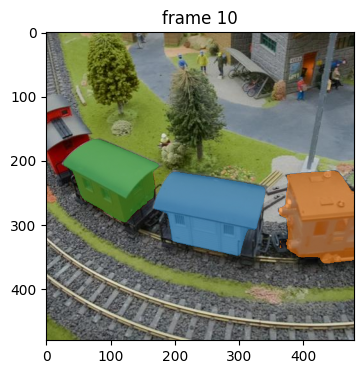

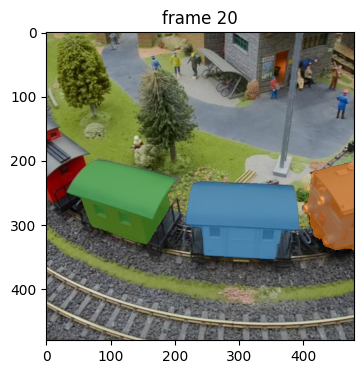

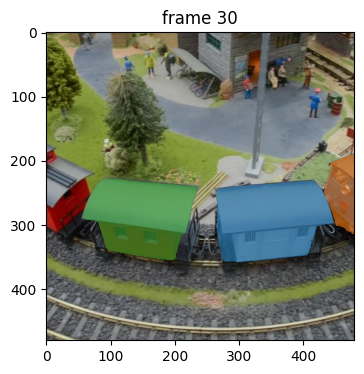

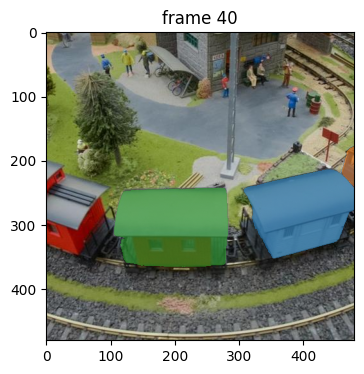

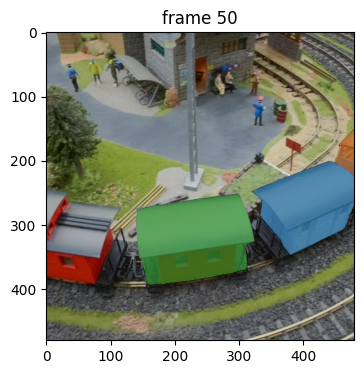

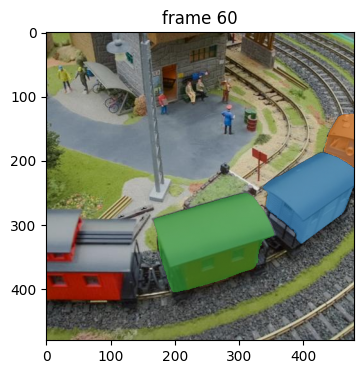

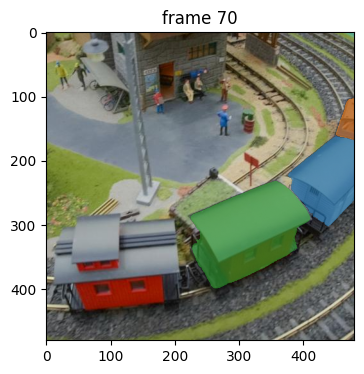

In [16]:
#run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results

first_frame_pix_feats = [obj['cond_frame_outputs'][0]["pix_feats"].detach().cpu() for obj in inference_state['temp_output_dict_per_obj'].values() ]
first_frame_pix_feats = torch.cat(first_frame_pix_feats, dim=0)
all_pix_feats = {0: first_frame_pix_feats}

#all_pix_feats={}
for out_frame_idx, out_obj_ids, out_mask_logits, pix_feats in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    if out_frame_idx not in all_pix_feats:
        all_pix_feats[out_frame_idx] = pix_feats.detach().cpu()

all_pix_feats=[all_pix_feats[i] for i in range(len(all_pix_feats))]
all_pix_feats=torch.cat(all_pix_feats, dim=0)

print(all_pix_feats.shape)

# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)